# STA 141B Final Project
Fall 2018

Xavier Hung

Weiyi Chen

## Problem: Do red light cameras result in more speeding?
### Case study: Chicago

The red light camera is intended to increase public safety by preventing people from running a red light, but is it really effective?

A quick Google search revealed that most of the red light cameras result in more accidents, and the only purpose of the red light camera is to generate millions of revenue for the government as well as the private contractors that installed the cameras.  However, according to the Insurance Institute for Highway Safety (IIHS),  fatal accidents caused by speeding can be reduced by up to 19% after the installation of red light cameras. 

To verify this statement, we focused on the association between red light cameras and speeding. We will compare the number of speeding violations that occurred at intersections before and after the installation of red light camera. 

####  Data Extraction

We obtained our data from the City of Chicago. There are four CSV files: red light camera locations, red light camera violations, speed camera locations, and speed camera violations (details of these data can be found at https://data.cityofchicago.org/browse?q=red+light+camera&sortBy=relevance).

In [731]:
import os
import pandas as pd
import numpy as np
import math
from ast import literal_eval
from bokeh.plotting import figure, show, output_notebook
from bokeh.models.annotations import Title
from bokeh.tile_providers import CARTODBPOSITRON
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

redlight_loc = pd.read_csv('red-light-camera-locations.csv')
redlight_violations = pd.read_csv('red-light-camera-violations.csv')

speed_loc = pd.read_csv('speed-camera-locations.csv')
speed_violations = pd.read_csv('speed-camera-violations.csv')

`speed_loc` and `redlight_loc` have columns, latitude and longitude. We use Mercator projection to convert latitude and longitude into coordinates, and plot the locations of red light cameras and speed cameras.

In [732]:
# plot red light cameras and speed cameras locations
speed_loc["COORDINATES"] = '('+ speed_loc["LATITUDE"].astype(str) +','+ speed_loc["LONGITUDE"].astype(str) + ')'
redlight_loc["COORDINATES"] = '('+ redlight_loc["LATITUDE"].astype(str) +','+ redlight_loc["LONGITUDE"].astype(str) + ')'

def merc(Coords):
    Coordinates = literal_eval(Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

speed_loc['coords_x'] = speed_loc['COORDINATES'].apply(lambda x: merc(x)[0])
speed_loc['coords_y'] = speed_loc['COORDINATES'].apply(lambda x: merc(x)[1])

redlight_loc['coords_x'] = redlight_loc['COORDINATES'].apply(lambda x: merc(x)[0])
redlight_loc['coords_y'] = redlight_loc['COORDINATES'].apply(lambda x: merc(x)[1])

p = figure(x_range=(-9790000, -9735000), y_range=(5105000, 5165000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

p.circle(x = redlight_loc['coords_x'], y = redlight_loc['coords_y'], legend = "Red Light Camera", fill_color="#FF0000")
p.circle(x = speed_loc['coords_x'], y = speed_loc['coords_y'], legend = "Speed Camera")

t = Title()
t.text = 'Locations of All Speed Cameras and Red Light Cameras'
p.title = t

p.legend.location = "top_right"
p.legend.click_policy="hide"

output_notebook()
show(p)

Loading BokehJS ...

In Chicago, the 0.0001 longitude is about 111.2 meters when latitudes are same. When longtitude are same, the 0.0001 latitude is about 82.69 meters. 
link: https://www.movable-type.co.uk/scripts/latlong.html

We subset the data by red light cameras and speed cameras that are near each other by 0.0001 latitude and longitude. 

In [809]:
# redlight_loc_copy is a subset of redlight_loc and contains the locations of red light cameras near speed cameras
# speed_loc_copy is a subset of speed_loc and contains the locations of speed cameras near red light cameras
redlight_loc_copy = pd.DataFrame(columns = redlight_loc.columns.values)
speed_loc_copy = pd.DataFrame(columns = speed_loc.columns.values)
pairs = pd.DataFrame(columns = ['speed', 'redlight'])

# find red light cameras near speed cameras
for i in range(0,speed_loc.shape[0]):
    for j in range(0,redlight_loc.shape[0]):
        if abs(speed_loc.iloc[i,4] - redlight_loc.iloc[j,5]) < 0.001 and abs(speed_loc.iloc[i,5] - redlight_loc.iloc[j,6]) < 0.001:
            #if pd.to_datetime(speed_loc['GO-LIVE DATE']).dt.year[i] < pd.to_datetime(redlight_loc['GO LIVE DATE']).dt.year[j]:
            redlight_loc_copy = redlight_loc_copy.append(redlight_loc.iloc[j], ignore_index = True)
            speed_loc_copy = speed_loc_copy.append(speed_loc.iloc[i], ignore_index = True)
            temp = pd.DataFrame({'speed': [speed_loc.iloc[i,0]], 'redlight': [redlight_loc.iloc[j,0]]})
            pairs = pairs.append(temp)
pairs = pairs.reset_index(drop = True)

In [812]:
# change format of addresses in speed_loc_copy to match format of addresses in speed_violations
remove = ["(Speed", "Camera)", "Ave", "ST", "Rd", "St", "Blvd"]
for i in range(0, speed_loc_copy.shape[0]):
    speed_loc_copy.iloc[i,0] = " ".join([word for word in speed_loc_copy.iloc[i,0].split() if word not in remove])

for i in range(0, pairs.shape[0]):
    pairs.iloc[i,0] = " ".join([word for word in pairs.iloc[i,0].split() if word not in remove]).upper()
    pairs.iloc[i,1] = pairs.iloc[i,1].upper()

speed_violations_copy = pd.DataFrame(columns = speed_violations.columns.values)    
    
# subset speed violations where speed cameras are near red light cameras
for i in range(0, speed_loc_copy.shape[0]):
    address = speed_violations[speed_violations['ADDRESS'].str.contains(speed_loc_copy.iloc[i,0].upper())]
    speed_violations_copy = speed_violations_copy.append(address, ignore_index = True)
    if len(address.index) > 0:
        pairs.iloc[i,0] = address.iloc[0,0]

In [813]:
redlight_violations_copy = pd.DataFrame(columns = redlight_violations.columns.values)

# subset red light violations where speed cameras are near red light cameras
# this will take a while
for i in range (0, redlight_violations.shape[0]):
    for j in range(0, redlight_loc_copy.shape[0]):
        intersection1 = redlight_violations.iloc[i,0].replace(' AND ', '/').replace(' and ', '/').split('/')
        intersection2 = redlight_loc_copy.iloc[j,0].split('-')
        if len(intersection1) > 1 and len(intersection2) > 1:
            if intersection1[0] == intersection2[0].upper() or intersection1[0] == intersection2[1].upper():
                if intersection1[1] == intersection2[0].upper() or intersection1[1] == intersection2[1].upper():
                    redlight_violations_copy = redlight_violations_copy.append(redlight_violations.iloc[i], ignore_index = True)
                    pairs.iloc[j,1] = redlight_violations.iloc[i,0]

In [814]:
# plot red light cameras near speed cameras
redlight_loc_copy["COORDINATES"] = '('+ redlight_loc_copy["LATITUDE"].astype(str) +','+ redlight_loc_copy["LONGITUDE"].astype(str) + ')'
speed_loc_copy["COORDINATES"] = '('+ speed_loc_copy["LATITUDE"].astype(str) +','+ speed_loc_copy["LONGITUDE"].astype(str) + ')'

speed_loc_copy['coords_x'] = speed_loc_copy['COORDINATES'].apply(lambda x: merc(x)[0])
speed_loc_copy['coords_y'] = speed_loc_copy['COORDINATES'].apply(lambda x: merc(x)[1])

redlight_loc_copy['coords_x'] = redlight_loc_copy['COORDINATES'].apply(lambda x: merc(x)[0])
redlight_loc_copy['coords_y'] = redlight_loc_copy['COORDINATES'].apply(lambda x: merc(x)[1])

p = figure(x_range=(-9780000, -9745000), y_range=(5120000, 5160000),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)

p.circle(x = redlight_loc_copy['coords_x'], y = redlight_loc_copy['coords_y'], legend = "Red Light Camera", fill_color="#FF0000")
p.circle(x = speed_loc_copy['coords_x'], y = speed_loc_copy['coords_y'], legend = "Speed Camera",)

t = Title()
t.text = 'Speed Cameras in Close Proximity to Red Light Cameras'
p.title = t

p.legend.location = "top_right"
p.legend.click_policy="hide"

output_notebook()
show(p)

Loading BokehJS ...

In [815]:
# find intersections that have the most and least red light violations and speed vioalations
redlight = redlight_violations_copy.groupby('INTERSECTION')['VIOLATIONS'].sum().sort_values(ascending = False)
most_redlight_violations = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(redlight.axes[0][0])].reset_index(drop = True)
second_redlight_violations = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(redlight.axes[0][1])].reset_index(drop = True)
third_redlight_violations = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(redlight.axes[0][2])].reset_index(drop = True)
least_redlight_violations = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(redlight.axes[0][len(redlight) - 1])].reset_index(drop = True)

speed = speed_violations_copy.groupby('ADDRESS')['VIOLATIONS'].sum().sort_values(ascending = False)
most_speed_violations = speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(speed.axes[0][0])].reset_index(drop = True)
least_speed_violations = speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(speed.axes[0][len(speed) - 1])].reset_index(drop = True)

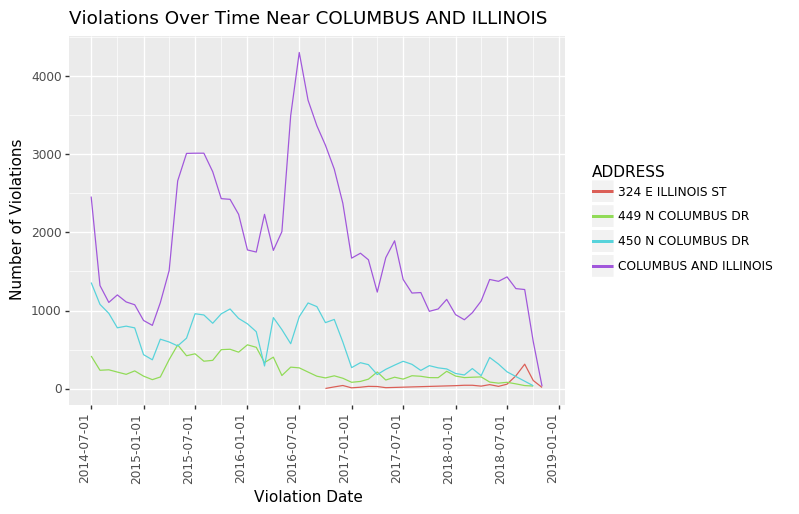

<ggplot: (313730319)>


In [816]:
# most_redlight_violations and most_redlight_speed are pairs
most_redlight_speed = pd.DataFrame()
temp = pairs.loc[pairs['redlight'] == most_redlight_violations.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
for i in range (0, len(temp)):
    most_redlight_speed = most_redlight_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[i])].reset_index(drop = True))

most_redlight_speed['date'] = pd.to_datetime(most_redlight_speed['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
most_redlight_speed['date'] = pd.to_datetime(most_redlight_speed['date'])
temp = most_redlight_speed.groupby(['ADDRESS', 'date'])['VIOLATIONS'].sum()
plotdata = pd.DataFrame({'ADDRESS': temp.index.get_level_values('ADDRESS'), 'date': temp.index.get_level_values('date'),'count': temp.values})

most_redlight_violations['date'] = pd.to_datetime(most_redlight_violations['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
most_redlight_violations['date'] = pd.to_datetime(most_redlight_violations['date'])
temp = most_redlight_violations.groupby('date')['VIOLATIONS'].sum()
plotdata = plotdata.append(pd.DataFrame({'date': temp.index.get_level_values('date'), 'count': temp.values,'ADDRESS': most_redlight_violations.iloc[0,0]}))

print(ggplot(aes(x = 'date', y = 'count', color = 'ADDRESS'), data = plotdata)
 + geom_line()
 + labs(x = 'Violation Date', y = 'Number of Violations')
 + theme(axis_text_x  = element_text(angle = 90, hjust = 1))
 + ggtitle('Violations Over Time Near ' + most_redlight_violations.iloc[0,0]))

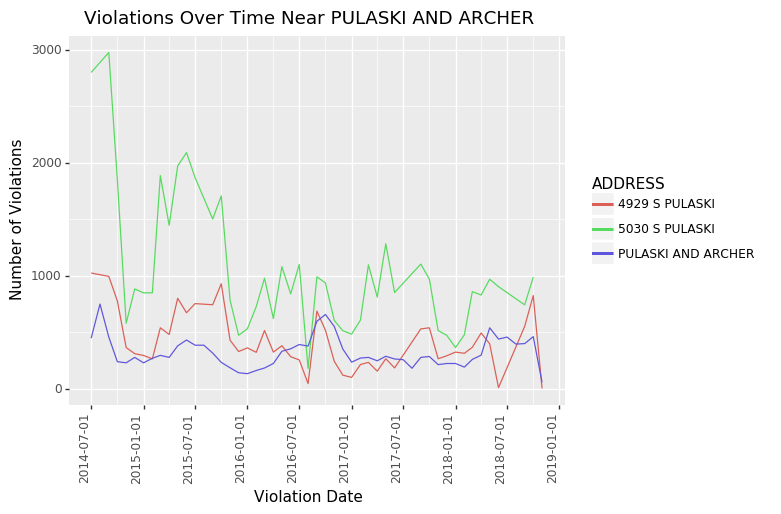

<ggplot: (318242273)>


In [817]:
# second_redlight_violations and second_redlight_speed are pairs
second_redlight_speed = pd.DataFrame()
temp = pairs.loc[pairs['redlight'] == second_redlight_violations.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
for i in range (0, len(temp)):
    second_redlight_speed = second_redlight_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[i])].reset_index(drop = True))

second_redlight_speed['date'] = pd.to_datetime(second_redlight_speed['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
second_redlight_speed['date'] = pd.to_datetime(second_redlight_speed['date'])
temp = second_redlight_speed.groupby(['ADDRESS', 'date'])['VIOLATIONS'].sum()
plot1data = pd.DataFrame({'ADDRESS': temp.index.get_level_values('ADDRESS'), 'date': temp.index.get_level_values('date'),'count': temp.values})

second_redlight_violations['date'] = pd.to_datetime(second_redlight_violations['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
second_redlight_violations['date'] = pd.to_datetime(second_redlight_violations['date'])
temp = second_redlight_violations.groupby('date')['VIOLATIONS'].sum()
plot1data = plot1data.append(pd.DataFrame({'date': temp.index.get_level_values('date'), 'count': temp.values,'ADDRESS': second_redlight_violations.iloc[0,0]}))

print(ggplot(aes(x = 'date', y = 'count', color = 'ADDRESS'), data = plot1data)
 + geom_line()
 + labs(x = 'Violation Date', y = 'Number of Violations')
 + theme(axis_text_x  = element_text(angle = 90, hjust = 1))
 + ggtitle('Violations Over Time Near ' + second_redlight_violations.iloc[0,0]))

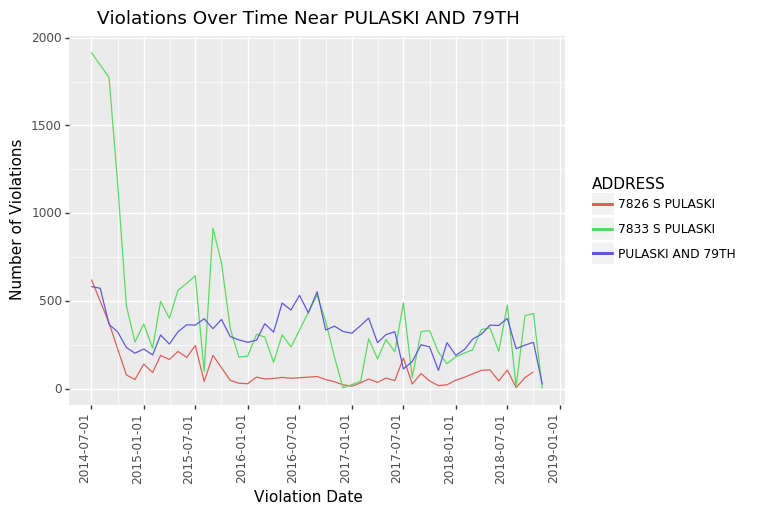

<ggplot: (292753423)>


In [818]:
# third_redlight_violations and third_redlight_speed are pairs
third_redlight_speed = pd.DataFrame()
temp = pairs.loc[pairs['redlight'] == third_redlight_violations.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
for i in range (0, len(temp)):
    third_redlight_speed = third_redlight_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[i])].reset_index(drop = True))

third_redlight_speed['date'] = pd.to_datetime(third_redlight_speed['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
third_redlight_speed['date'] = pd.to_datetime(third_redlight_speed['date'])
temp = third_redlight_speed.groupby(['ADDRESS', 'date'])['VIOLATIONS'].sum()
plot2data = pd.DataFrame({'ADDRESS': temp.index.get_level_values('ADDRESS'), 'date': temp.index.get_level_values('date'),'count': temp.values})

third_redlight_violations['date'] = pd.to_datetime(third_redlight_violations['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
third_redlight_violations['date'] = pd.to_datetime(third_redlight_violations['date'])
temp = third_redlight_violations.groupby('date')['VIOLATIONS'].sum()
plot2data = plot2data.append(pd.DataFrame({'date': temp.index.get_level_values('date'), 'count': temp.values,'ADDRESS': third_redlight_violations.iloc[0,0]}))

print(ggplot(aes(x = 'date', y = 'count', color = 'ADDRESS'), data = plot2data)
 + geom_line()
 + labs(x = 'Violation Date', y = 'Number of Violations')
 + theme(axis_text_x  = element_text(angle = 90, hjust = 1))
 + ggtitle('Violations Over Time Near ' + third_redlight_violations.iloc[0,0]))

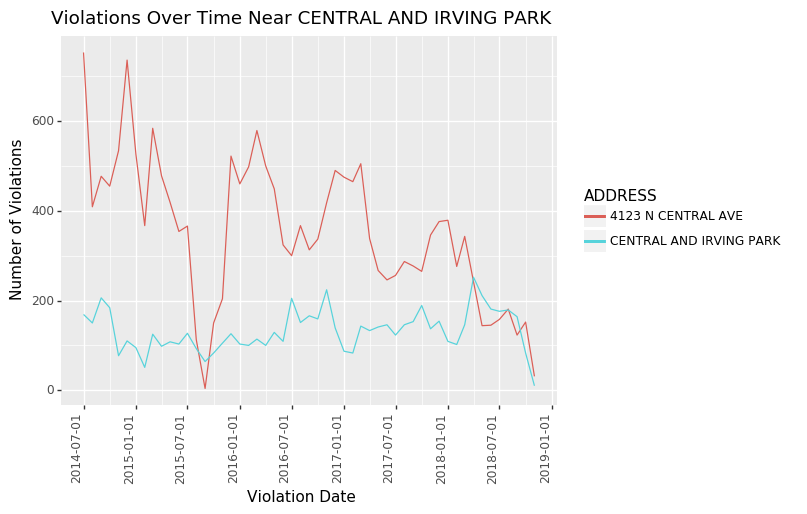

<ggplot: (-9223372036541240986)>


In [819]:
# least_redlight_violations and least_redlight_speed are pairs
least_redlight_speed = pd.DataFrame()
temp = pairs.loc[pairs['redlight'] == least_redlight_violations.iloc[0,0]].reset_index(drop = True).iloc[:, 0].tolist()
for i in range (0, len(temp)):
    least_redlight_speed = least_redlight_speed.append(speed_violations_copy.loc[speed_violations_copy['ADDRESS'].str.contains(temp[i])].reset_index(drop = True))

least_redlight_speed['date'] = pd.to_datetime(least_redlight_speed['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
least_redlight_speed['date'] = pd.to_datetime(least_redlight_speed['date'])
temp = least_redlight_speed.groupby(['ADDRESS', 'date'])['VIOLATIONS'].sum()
plot3data = pd.DataFrame({'ADDRESS': temp.index.get_level_values('ADDRESS'), 'date': temp.index.get_level_values('date'),'count': temp.values})

least_redlight_violations['date'] = pd.to_datetime(least_redlight_violations['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
least_redlight_violations['date'] = pd.to_datetime(least_redlight_violations['date'])
temp = least_redlight_violations.groupby('date')['VIOLATIONS'].sum()
plot3data = plot3data.append(pd.DataFrame({'date': temp.index.get_level_values('date'), 'count': temp.values,'ADDRESS': least_redlight_violations.iloc[0,0]}))

print(ggplot(aes(x = 'date', y = 'count', color = 'ADDRESS'), data = plot3data)
 + geom_line()
 + labs(x = 'Violation Date', y = 'Number of Violations')
 + theme(axis_text_x  = element_text(angle = 90, hjust = 1))
 + ggtitle('Violations Over Time Near ' + least_redlight_violations.iloc[0,0]))

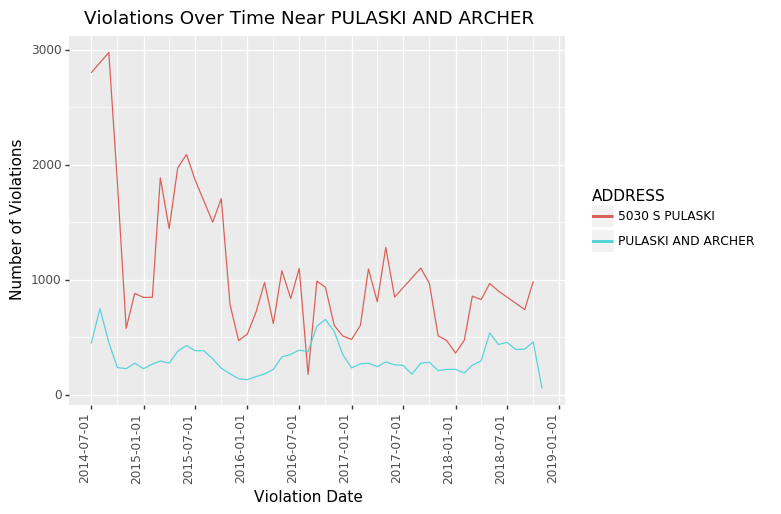

<ggplot: (318086180)>


In [820]:
# most_speed_violations and most_speed_redlight are pairs
most_speed_redlight = pd.DataFrame()
temp = pairs.loc[pairs['speed'] == most_speed_violations.iloc[0,0]].reset_index(drop = True)['redlight'].iloc[0]
most_speed_redlight = most_speed_redlight.append(redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(temp)].reset_index(drop = True))

most_speed_violations['date'] = pd.to_datetime(most_speed_violations['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
most_speed_violations['date'] = pd.to_datetime(most_speed_violations['date'])
temp = most_speed_violations.groupby(['ADDRESS', 'date'])['VIOLATIONS'].sum()
plot4data = pd.DataFrame({'ADDRESS': temp.index.get_level_values('ADDRESS'), 'date': temp.index.get_level_values('date'),'count': temp.values})

most_speed_redlight['date'] = pd.to_datetime(most_speed_redlight['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
most_speed_redlight['date'] = pd.to_datetime(most_speed_redlight['date'])
temp = most_speed_redlight.groupby('date')['VIOLATIONS'].sum()
plot4data = plot4data.append(pd.DataFrame({'date': temp.index.get_level_values('date'), 'count': temp.values,'ADDRESS': most_speed_redlight.iloc[0,0]}))

print(ggplot(aes(x = 'date', y = 'count', color = 'ADDRESS'), data = plot4data)
 + geom_line()
 + labs(x = 'Violation Date', y = 'Number of Violations')
 + theme(axis_text_x  = element_text(angle = 90, hjust = 1))
 + ggtitle('Violations Over Time Near ' + most_speed_redlight.iloc[0,0]))

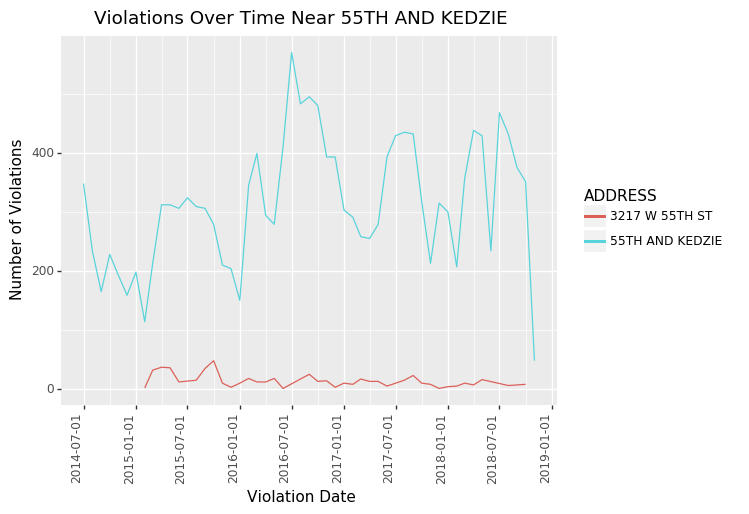

<ggplot: (-9223372036541029183)>


In [821]:
# least_speed_violations and least_speed_redlight are pairs
least_speed_redlight = pd.DataFrame()
temp = pairs.loc[pairs['speed'] == least_speed_violations.iloc[0,0]].reset_index(drop = True)['redlight'].iloc[0]
least_speed_redlight = redlight_violations_copy.loc[redlight_violations_copy['INTERSECTION'].str.contains(temp)].reset_index(drop = True)

least_speed_violations['date'] = pd.to_datetime(least_speed_violations['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
least_speed_violations['date'] = pd.to_datetime(least_speed_violations['date'])
temp = least_speed_violations.groupby(['ADDRESS', 'date'])['VIOLATIONS'].sum()
plot5data = pd.DataFrame({'ADDRESS': temp.index.get_level_values('ADDRESS'), 'date': temp.index.get_level_values('date'),'count': temp.values})

least_speed_redlight['date'] = pd.to_datetime(least_speed_redlight['VIOLATION DATE']).apply(lambda x: x.strftime('%Y-%m'))
least_speed_redlight['date'] = pd.to_datetime(least_speed_redlight['date'])
temp = least_speed_redlight.groupby('date')['VIOLATIONS'].sum()
plot5data = plot5data.append(pd.DataFrame({'date': temp.index.get_level_values('date'), 'count': temp.values,'ADDRESS': least_speed_redlight.iloc[0,0]}))

print(ggplot(aes(x = 'date', y = 'count', color = 'ADDRESS'), data = plot5data)
 + geom_line()
 + labs(x = 'Violation Date', y = 'Number of Violations')
 + theme(axis_text_x  = element_text(angle = 90, hjust = 1))
 + ggtitle('Violations Over Time Near ' + least_speed_redlight.iloc[0,0]))